In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [11]:
recs_codebook_df = pd.read_excel('recs2020_codebook.xlsx', header=1)
recs_data = pd.read_csv('recs2020_data.csv')

In [12]:
# Remove the 'End-use Model' columns to avoid any columns to avoid using the output of another model as an input to ours.
cols_to_remove = recs_codebook_df[recs_codebook_df['Section'] == 'End-use Model'].Variable.unique().tolist()
more_cols_to_keep = [col for col in recs_data.columns if col not in cols_to_remove]

# Subset the dataframe to remove unnecessary columns
big_subset_df = recs_data[more_cols_to_keep]

In [13]:
imputer = SimpleImputer(strategy='median')
num_df = big_subset_df.select_dtypes(include=['number'])
num_df_imputed = pd.DataFrame(imputer.fit_transform(num_df), columns=num_df.columns)


In [14]:
categorical_df = big_subset_df.select_dtypes(exclude=['number'])
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_df_imputed = pd.DataFrame(cat_imputer.fit_transform(categorical_df), columns=categorical_df.columns)


In [15]:
# Normalize numeric columns using MinMaxScaler
scaler = MinMaxScaler()
normalized_num_df = pd.DataFrame(scaler.fit_transform(num_df_imputed), columns=num_df_imputed.columns)

# One-hot encode the categorical columns
one_hot_encoded_df = pd.get_dummies(categorical_df_imputed)

# Combine the numeric and categorical dataframes
final_df = pd.concat([normalized_num_df, one_hot_encoded_df], axis=1)


In [16]:
final_df.head()

,DOEID,STATE_FIPS,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,TYPEHUQ,CELLAR,CRAWL,CONCRETE,...,IECC_climate_code_5B,IECC_climate_code_6A,IECC_climate_code_6B,IECC_climate_code_7A,IECC_climate_code_7AK,IECC_climate_code_7B,IECC_climate_code_8AK,UATYP10_C,UATYP10_R,UATYP10_U
0,0.000000,0.618182,0.221136,0.303397,0.276958,0.209378,0.25,0.666667,0.666667,1.000000,...,False,False,False,False,False,False,False,False,False,True
1,0.000054,0.072727,0.216648,0.263462,0.275590,0.266055,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
2,0.000108,0.618182,0.219697,0.306469,0.280007,0.205912,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
3,0.000162,0.800000,0.150377,0.310445,0.200921,0.337003,0.25,0.666667,1.000000,0.666667,...,False,False,False,False,False,False,False,False,False,True
4,0.000216,0.600000,0.242708,0.246296,0.304648,0.215902,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True


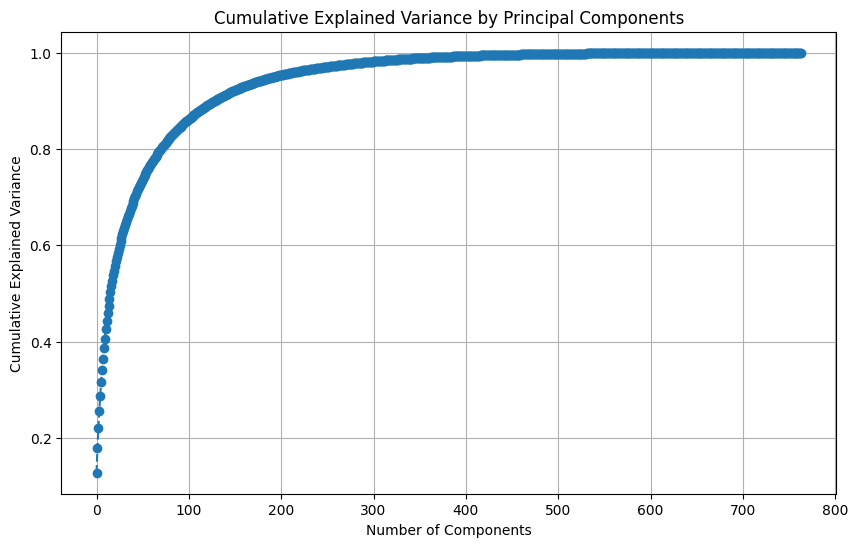

In [18]:
# Perform PCA again but without limiting to just 2 components
pca = PCA()
pca_result = pca.fit_transform(final_df)

# Calculate the cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [19]:
# Find the number of components that explain at least 90% of the variance
explained_variance_90 = np.where(explained_variance >= 0.90)[0][0] + 1  # +1 to get the actual component count
explained_variance_95 = np.where(explained_variance >= 0.95)[0][0] + 1  # +1 to get the actual component count

print(f"Number of components explaining 90% variance: {explained_variance_90}")
print(f"Number of components explaining 95% variance: {explained_variance_95}")


Number of components explaining 90% variance: 129
Number of components explaining 95% variance: 194


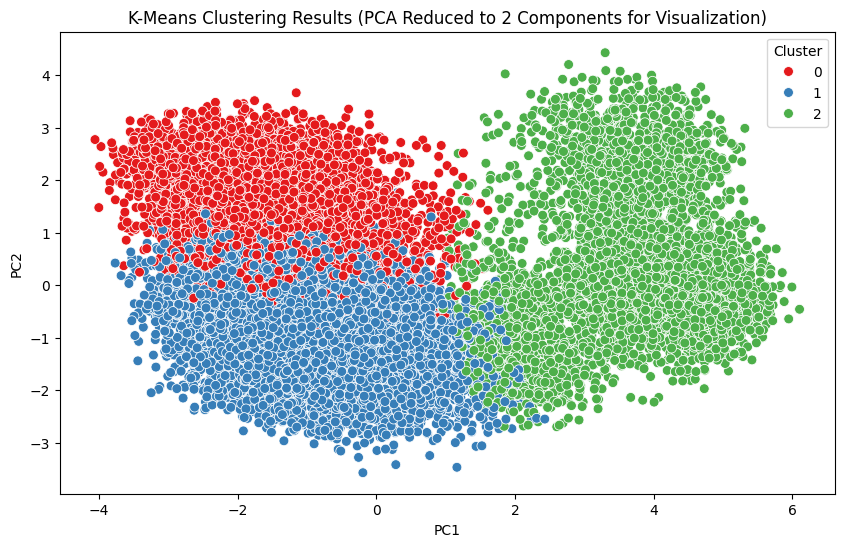

In [20]:
# Reduce the data to 129 components (for 90% variance)
pca_90 = PCA(n_components=129)
pca_90_result = pca_90.fit_transform(final_df)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Add the K-means cluster labels to the PCA dataframe
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(final_df)

# Convert the first two principal components into a dataframe for visualization
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])

# Add the K-means cluster labels to the PCA dataframe
pca_df['Cluster'] = kmeans_labels

# Plot the PCA result with K-means cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components for Visualization)')
plt.show()


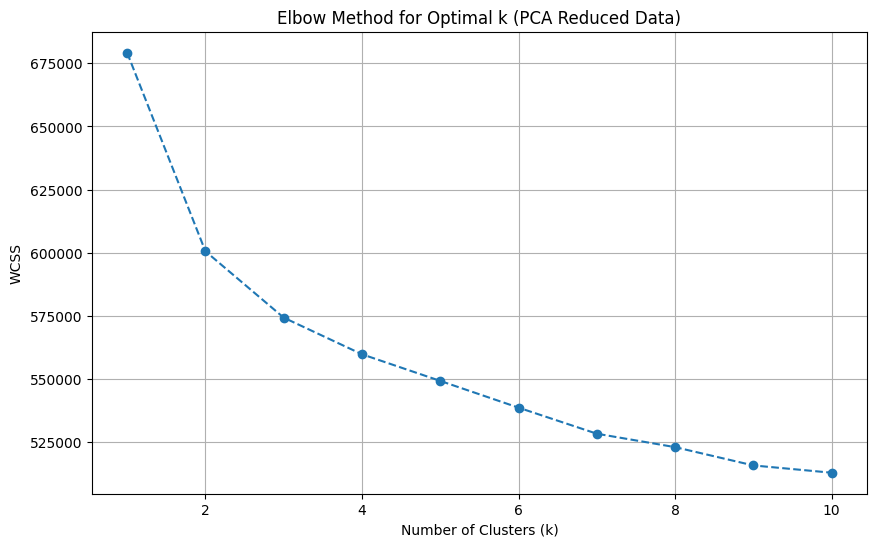

In [21]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)  # Test for k values from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)  # Use your 129-component PCA result here
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

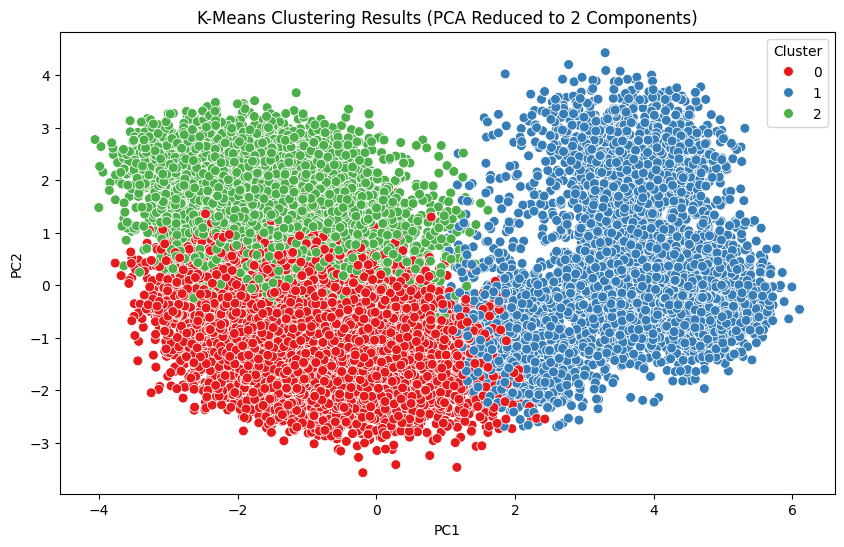

In [22]:
# Perform K-means clustering with the chosen k (3 or 4)
kmeans = KMeans(n_clusters=3, random_state=42)  # Change to 4 if desired
kmeans_labels = kmeans.fit_predict(pca_90_result)  # Use the PCA-reduced data (129 components)

# Visualize using the first two principal components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

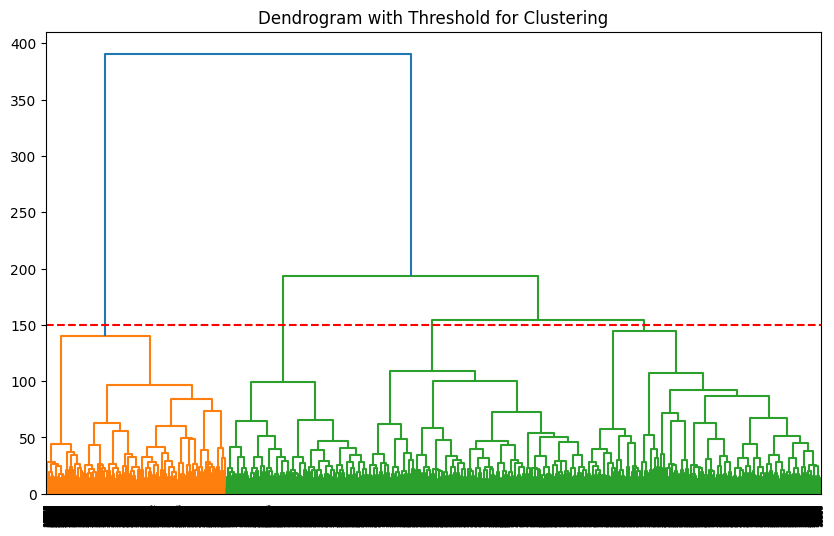

In [23]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.axhline(y=150, color='r', linestyle='--')  # Adjust the y-value to focus on higher levels of clustering
plt.show()


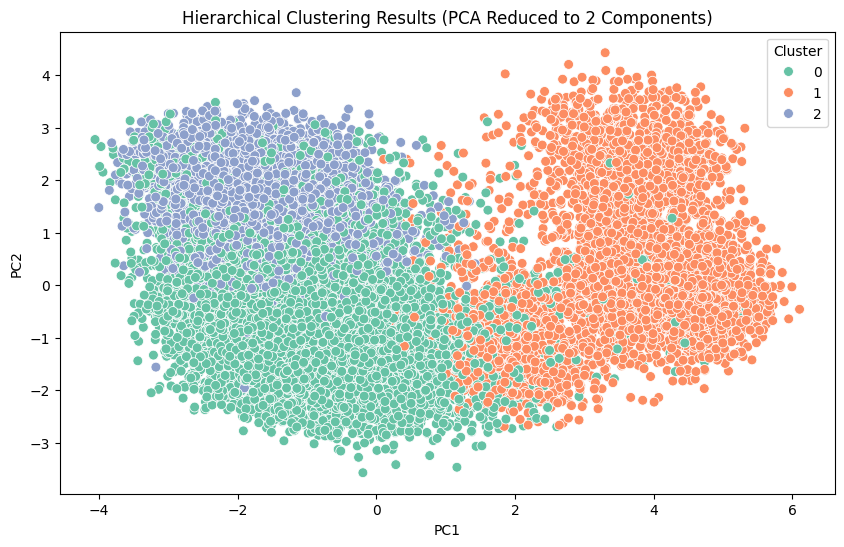

In [24]:
# Perform Hierarchical Clustering with 3 clusters
hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  # Use your 129-component PCA data

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()